<a href="https://colab.research.google.com/github/Bast-94/RL-DQN/blob/dqn-draft/RL_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet de Reinforcement Learning : Deep Q-Learning sur le casse-brique d'Atari

In [1]:
! pip install -q gymnasium["atari","accept-rom-license"]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 9.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.6 MB/s eta 0:00:00


## Présentation globale du projet

### Objectifs du projet

### Algorithme principal

#### Pseudo code de l'algorithme


$\text{Algorithme de Q-Leearning profond avec répétition d'expérience}$
1. **Initialisation:**
   - Initialiser le réseau de neurones $Q$ avec des poids aléatoires.
   - Initialiser la mémoire de relecture $D$ avec capacité maximale $N$.
   - Initialiser aléatoirement les paramètres d'apprentissage.
   - Initialiser la fonction $Q$ avec des $\theta$ aléatoire.
   - Initialiser $\hat{Q}$ avec $\theta^⁻ = \theta$.

2. **Pour chaque épisode:**
   - Initialiser l'environnement et l'état initial $s_1=\{x_1\}$
   - Appliquer le prétraitement $\phi_1 = \phi(s_1)$
   
   3. **Pour chaque étape $t$ de l'épisode:**
      - Choisir l'action $a_t$ avec la politique $\varepsilon$-greedy
        - $\mathbb{P}(a_t = argmax_a(Q(s_t,a;\theta)) = 1 - \varepsilon$
        - $\mathbb{P}(a_t = \text{random\_sample(}A)) = \varepsilon$
      - Exécuter l'action $a_t$, observer la récompense $r_t$ et l'état suivant $s_{t+1}$
      - Stocker la transition $(s_t, a_t, r_{t}, s_{t+1})$ dans la mémoire de relecture $D$
      - Affecter $s_{t+1}=s_t,a_t,x_{t+1}$
      - Prétraitement de $s_{t+1}$ : $\phi_{t+1}=\phi(s_{t+1})$
      - Échantillonner un lot aléatoire de transitions $(s_i, a_i, r_i, s_{i+1})$ de $D$
      - Calculer la vérité terrain $y_i$ pour chaque transition $(s_i, a_i, r_i, s_{i+1})$ en utilisant le réseau $\hat{Q}$ aux paramètre $\theta^-$
      - Cloner $Q$ dans $\hat{Q}$ toutes les $C$ étapes
      


#### Détails des variables
- $Q$ : Fonction de qualité qui pour un couple état-action évalue à quel point une action dans un état donné est favorable.
- $C$ : Nombre d'étapes à laquelle $\hat{Q}$ se met à jour sur $Q$.
- $\hat{Q}$ : Target Network , il correspond à une version ancienne de $Q$ avec des paramètres $\theta^-$ sur les $C$ dernières étapes.
- $\theta$ : Correspond aux paramètres du réseau de neurones.
- ${A}$ : L'ensemble des actions possibles.
- $a_t$ : L'action faite par l'agent à l'étape $t$.
- $x_t$ : Correspond à l'image brut du jeu à l'étape $t$.
- $s_t$ : Correspond à une séquence de couples action-image $\{a_i \times x_i\}_{i\lt t}$ .
- $\phi_t$ : Correspond au pré-traitement de l'état $s_t$ (Plus de détails dans la suite du notebook).
- $\varepsilon \in [0,1]$ : Probabilité de choisir une action aléatoire.
- $r_t$ : Récompense obtenue par la réalisation de l'action $a_t$ à l'instant $s_t$
- $D$ : Mémoire de relecture.
- $N$ : Nombre de simulations.

## Démarche de recherche et implémentation

In [2]:
from torch import nn
import torch
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.transforms as transforms
import copy

#### Prétraitement des données

In [3]:
def preprocess_image(img_array:np.array) -> np.array :
  transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((84, 84)),
      transforms.Grayscale(num_output_channels=1),
      transforms.ToTensor()])
  return transform(img_array)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


new_img.size() = torch.Size([1, 84, 84])


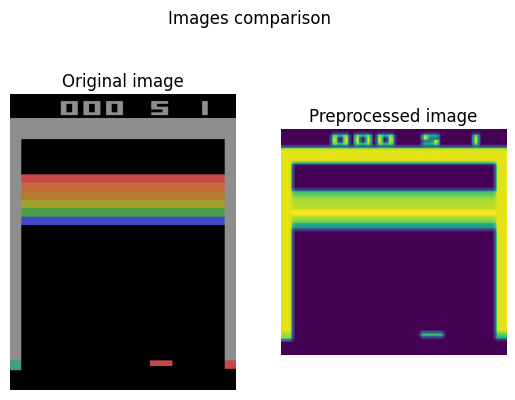

In [4]:
env = gym.make('ALE/Breakout-v5', render_mode="rgb_array")
state_img = env.reset()[0]
fig,axes = plt.subplots(1,2)
fig.suptitle('Images comparison')
axes[0].set_title('Original image')
axes[0].imshow(state_img)
axes[0].axis('off')
new_img = preprocess_image(state_img)
print(f'{new_img.size() = }')
axes[1].axis('off')
axes[1].set_title('Preprocessed image')
axes[1].imshow(new_img.permute(1,2,0))

### Elaboration d'un modèle de de DQN

In [5]:
class DQN(nn.Module):
  def __init__(self,n_action,height,width,linear_size=512,model_name:str=None):
    super(DQN, self).__init__()
    self.input_dimension = 1, height,width
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=self.input_dimension[0],out_channels=32,kernel_size=8),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )

    x0 = torch.zeros(1,*self.input_dimension)
    x0 = self.conv_layers(x0)
    flatten_dim = int(np.prod(x0.shape))

    linear_size = 512
    self.linear_layers = nn.Sequential(
        nn.Linear(flatten_dim, linear_size),
        nn.ReLU(),
        nn.Linear(linear_size,n_action)
    )


  def forward(self,x):
    x = self.conv_layers(x)
    x = x.view(x.shape[0],-1)
    return self.linear_layers(x)



def create_model_from_env(env: gym.Env):

  env_tensor = np.zeros(env.observation_space.shape,dtype=np.uint8)
  x = preprocess_image(env_tensor)
  _,height, width = x.shape
  n_action=env.action_space.n
  dqn = DQN(n_action=n_action,height=height, width=width)
  return dqn

testons

In [6]:
env = gym.make('ALE/Breakout-v5', render_mode="rgb_array")
dqn = create_model_from_env(env)
x = preprocess_image(env.reset()[0])
x = x.unsqueeze(0)
output = dqn(x)
assert output.size(1) == env.action_space.n, print(f'{output.size(1)} != {env.action_space.n}')
print("Les shapes de sortie du modèle sont cohérentes.")


Les shapes de sortie du modèle sont cohérentes.


#### Gestion de la mémoire des expériences

In [157]:
from collections import namedtuple
class GameTransition():
  tupled_transition = namedtuple('game_transition', ('initial_state', 'action', 'reward','next_state', 'done'))
  def __init__(self, initial_state, action, reward, next_state, done):
    self.initial_state = initial_state
    self.action = action
    self.reward = reward
    self.next_state = next_state
    self.done = done
  def to_named_tuple(self):
    return self.tupled_transition(self.initial_state, self.action, self.reward, self.next_state, self.done)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [152]:
class ExpStack(): # D
  def __init__(self, max_size:int):
    self.transitions = []
    self.max_size = max_size # N

  def enqueue(self,transition:GameTransition):
    if (len(self.transitions) >= self.max_size):
      return
    self.transitions.append(transition)

  def get_experiences(self,nb_exp=1):
    return random.sample(self.transitions, nb_exp)

  def __len__(self):
    return len(self.transitions)

  def __getitem__(self,index):
    return self.transitions[index]

  def sample_minibatch(self,batch_size:int=32):
    if (batch_size>=len(self)):
      return self.transitions
    ind = random.randint(0,len(self)-batch_size)
    return self[ind:ind+batch_size]

### Lancement du modèle sur l'algorithme **"deep Q-learning with experience replay."** issu de l'article

In [145]:
Action = int
State = torch.Tensor

In [153]:
class DQNAgent():
  def __init__(self, env: gym.Env, nb_episodes:int = int(2e3), max_step:int = int(1e5),max_experiences:int = int(1e5),update_frequency:int=5, epsilon:float = 0.05,batch_size:int=32,gamma:float=0.9,verbose:bool=True):
    self.env = env
    self.nb_episodes = nb_episodes
    self.max_step = max_step
    self.model = create_model_from_env(env)
    self.target_model = copy.deepcopy(self.model)
    self.experiences = ExpStack(max_size=max_experiences)
    self.step_index = 0
    self.episode_index = 0
    self.verbose = verbose
    self.update_frequency = update_frequency
    self.epsilon = epsilon
    self.current_state = None
    self.legal_actions = list(range(env.action_space.n))
    self.batch_size = batch_size
    self.gamma = gamma


  def train_agent(self):
    while(self.episode_index < self.nb_episodes):
      self.reset_game()
      self.make_episode()
      self.episode_index +=1
      if(self.verbose and self.episode_index % 100==0):
        print(f'{self.episode_index}/{self.nb_episodes} episodes are done')

  def make_episode(self):
    done = False
    while(self.step_index <self.max_step and not done):
      # Initialize State 1 # TODO
      current_state = preprocess_image(self.env.reset()[0])
      self.current_state = current_state
      self.make_step(current_state)
      self.step_index +=1

  def make_step(self,current_state: State | None = None):
    # Get action a_t
    a_t = self.get_action(current_state=current_state)
    # Make action and retrieve r_t and x_t
    next_state,reward,done,info = self.make_action(a_t)
    # Store transition
    transition = GameTransition(current_state,action,reward,next_state,done)
    self.experiences.enqueue(transition)
    # Sample minibatch of transitions
    mini_batch = self.get_minibatch()
    self.learn(mini_batch)
    if(self.step_index % self.update_frequency == 0):
      self.update_parameters()

    # make update according to step_index and update frequency # TODO

  def get_minibatch(self):
    return self.experiences.sample_minibatch(self.batch_size)

  def learn(self,mini_batch:list[GameTransition]) -> None:
    y = self.generate_y(mini_batch)


  def generate_y(self,mini_batch:list[GameTransition]) -> torch.Tensor:
    # Apply Bellman's equation
    y = []
    q_values = []
    self.model.train()
    for transition in mini_batch:
      y_j = transition.reward
      if (not transition.done):

        next_state = transition.next_state.unsqueeze(0)
        maximum_q_hat = self.target_model(next_state).max().item()
        y_j += self.gamma * maximum_q_hat
      #q_values.append()
      y.append(y_j)

    assert len(y) == len(mini_batch), "Size problem between y and minibatch"
    y_tensor = torch.tensor(y)
    y_tensor = y_tensor.unsqueeze(1)
    assert y_tensor.shape == (len(mini_batch),1), "Tensor size problem between y and minibatch"
    return y_tensor
    # perform gradient descent # TODO

  def make_action(self, action: Action) -> tuple[State,float, bool,dict]:
    state,reward,truncated, terminated,info = self.env.step(action)
    next_state = preprocess_image(state)
    done = truncated or terminated
    return next_state,reward,done,info


  def get_action(self,current_state: State) -> Action:
    if(random.random() < self.epsilon):
      return random.choice(self.legal_actions)

    current_state = current_state.unsqueeze(0)
    model_output = self.model(current_state)
    action = model_output.argmax().item()
    return action

  def update_parameters(self) -> None:
    pass

  def gradient_descent(self):
    pass

  def reset_game(self):
    self.step_index = 0
agent = DQNAgent(env,nb_episodes=1, max_step = 32)
#agent.train_agent()

In [154]:
agent.generate_y(agent.get_minibatch())

tensor([], size=(0, 1))

In [164]:
agent.train_agent()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[<__main__.GameTransition object at 0x7f58a9cc7b50>, <__main__.GameTransition object at 0x7f5891bf2da0>, <__main__.GameTransition object at 0x7f5891bf0cd0>, <__main__.GameTransition object at 0x7f589407fb50>, <__main__.GameTransition object at 0x7f58a9c5aa70>, <__main__.GameTransition object at 0x7f5891bf2200>, <__main__.GameTransition object at 0x7f5891bf3e80>, <__main__.GameTransition object at 0x7f5891bf3cd0>, <__main__.GameTransition object at 0x7f5891bf2e90>, <__main__.GameTransition object at 0x7f5891bf3370>, <__main__.GameTransition object at 0x7f5891bf0c10>, <__main__.GameTransition object at 0x7f5891bf2e00>, <__main__.GameTransition object at 0x7f5891bf3280>, <__main__.GameTransition object at 0x7f58a9cc74f0>, <__main__.GameTransition object at 0x7f58a9cc5b70>, <__main__.GameTransition object at 0x7f58a9cc6ad0>, <__main__.GameTransition object at 0x7f58a9cc4eb0>, <__main__.GameTransition object at 0x7f5891bf1450>, <__main__.GameTransition object at 0x7f58a9cc75b0>, <__main__.G

In [165]:
batch = agent.get_minibatch()
print(batch)
clean_batch = [transition.to_named_tuple() for transition in batch]
print(clean_batch)

[<__main__.GameTransition object at 0x7f58a9cc7b50>, <__main__.GameTransition object at 0x7f5891bf2da0>, <__main__.GameTransition object at 0x7f5891bf0cd0>, <__main__.GameTransition object at 0x7f589407fb50>, <__main__.GameTransition object at 0x7f58a9c5aa70>, <__main__.GameTransition object at 0x7f5891bf2200>, <__main__.GameTransition object at 0x7f5891bf3e80>, <__main__.GameTransition object at 0x7f5891bf3cd0>, <__main__.GameTransition object at 0x7f5891bf2e90>, <__main__.GameTransition object at 0x7f5891bf3370>, <__main__.GameTransition object at 0x7f5891bf0c10>, <__main__.GameTransition object at 0x7f5891bf2e00>, <__main__.GameTransition object at 0x7f5891bf3280>, <__main__.GameTransition object at 0x7f58a9cc74f0>, <__main__.GameTransition object at 0x7f58a9cc5b70>, <__main__.GameTransition object at 0x7f58a9cc6ad0>, <__main__.GameTransition object at 0x7f58a9cc4eb0>, <__main__.GameTransition object at 0x7f5891bf1450>, <__main__.GameTransition object at 0x7f58a9cc75b0>, <__main__.G

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
